MNIST Hand-written Digit Recognition

(a) Code a function that displays at least one image per each digit.

In [274]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
traindata = pd.read_csv("train.csv")

In [275]:
data = pd.DataFrame(data=traindata)

In [276]:
target = data.loc[:,'label']

<Figure size 432x288 with 0 Axes>

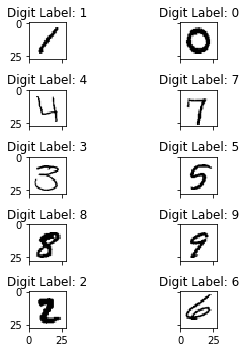

In [277]:
images_to_plot = 10
indices = target.drop_duplicates()

sample_images = data.drop_duplicates('label').drop("label", axis=1)
sample_labels = target.drop_duplicates()

plt.clf()
plt.style.use('seaborn-muted')

fig, axes = plt.subplots(5,2, 
                         figsize=(5,5),
                         sharex=True, sharey=True)

for i in range(images_to_plot):
    
    # axes (subplot) objects are stored in 2d array, accessed with axes[row,col]
    subplot_row = i//2 
    subplot_col = i%2
    ax = axes[subplot_row, subplot_col]

    # plot image on subplot
    plottable_image = np.reshape(sample_images.iloc[i,:].values, (28,28))
    ax.imshow(plottable_image, cmap='gray_r')
    
    ax.set_title('Digit Label: {}'.format(sample_labels.iloc[i]))
    ax.set_xbound([0,28])

plt.tight_layout()
plt.show()

(b) Measure the distribution over the labels in the training data.

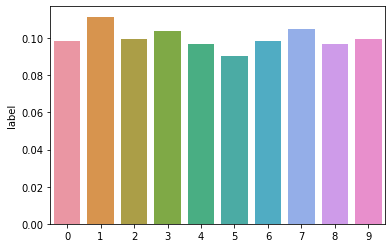

In [279]:
distribution = target.value_counts(normalize=True)
import seaborn
seaborn.barplot(x=distribution.index, y=distribution)

We observe that the distribution of digits in the training data is almost uniform so it is fit for modelling. Digit 1 has slightly more rows in the data compared to digit 5.

(d) Implement a neural-net classifier with varying the number of hidden layers and neurons there.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# train test split from sklearn
from sklearn.model_selection import train_test_split

# Import Torch 
import torch
import torch.nn as nn
from torchvision import transforms, models

from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F


test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
sample_sub = pd.read_csv("sample_submission.csv")

In [6]:
# Seperate the features and labels and normalize them on scale of 0-1
targets_np = train.label.values
features_np = train.loc[:, train.columns != 'label'].values/255

# Split into training and test set
features_train, features_test, target_train, target_test = train_test_split(features_np, targets_np, test_size=0.2, random_state=42)

In [7]:
# create feature and targets tensor for train set
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(target_train).type(torch.LongTensor)

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(target_test).type(torch.LongTensor)

In [8]:
# Set batch size
batch_size = 256

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)
    
# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [9]:
#Train-Test data distribution
print(featuresTrain.shape)
print(featuresTest.shape)

torch.Size([33600, 784])
torch.Size([8400, 784])


In [10]:
class Classifier1(nn.Module):
    def __init__(self):
        super().__init__()
        # 5 Hidden Layer Network
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 probbability
        self.dropout = nn.Dropout(p=0.2)
        # Add softmax on output layer
        self.log_softmax = F.log_softmax
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        
        x = self.log_softmax(self.fc5(x), dim=1)
        
        return x

In [11]:
class Classifier2(nn.Module):
    def __init__(self):
        super().__init__()
        # 5 Hidden Layer Network
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 probbability
        self.dropout = nn.Dropout(p=0.2)
        # Add softmax on output layer
        self.log_softmax = F.log_softmax
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = self.log_softmax(self.fc4(x), dim=1)
        
        return x

In [12]:
class Classifier3(nn.Module):
    def __init__(self):
        super().__init__()
        # 5 Hidden Layer Network
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 probbability
        self.dropout = nn.Dropout(p=0.2)
        # Add softmax on output layer
        self.log_softmax = F.log_softmax
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        
        x = self.log_softmax(self.fc3(x), dim=1)
        
        return x

In [12]:
# Instantiate model 1
model = Classifier1()
# Define our loss function
criterion = nn.NLLLoss()
# Define the optimier
optimizer = optim.Adam(model.parameters(), lr=0.0015)

epochs = 25
steps = 0
print_every = 50
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        # Prevent accumulation of gradients
        optimizer.zero_grad()
        # Make predictions
        log_ps = model(images.float())
        loss = criterion(log_ps, labels)
        #backprop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    log_ps = model(images.float())
                    test_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    # Get our top predictions
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/25..  Training Loss: 0.438..  Test Loss: 0.432..  Test Accuracy: 0.870
Epoch: 1/25..  Training Loss: 0.596..  Test Loss: 0.292..  Test Accuracy: 0.911
Epoch: 2/25..  Training Loss: 0.035..  Test Loss: 0.202..  Test Accuracy: 0.941
Epoch: 2/25..  Training Loss: 0.114..  Test Loss: 0.189..  Test Accuracy: 0.942
Epoch: 2/25..  Training Loss: 0.186..  Test Loss: 0.149..  Test Accuracy: 0.954
Epoch: 3/25..  Training Loss: 0.043..  Test Loss: 0.147..  Test Accuracy: 0.957
Epoch: 3/25..  Training Loss: 0.099..  Test Loss: 0.133..  Test Accuracy: 0.958
Epoch: 4/25..  Training Loss: 0.006..  Test Loss: 0.136..  Test Accuracy: 0.959
Epoch: 4/25..  Training Loss: 0.048..  Test Loss: 0.114..  Test Accuracy: 0.966
Epoch: 4/25..  Training Loss: 0.092..  Test Loss: 0.105..  Test Accuracy: 0.968
Epoch: 5/25..  Training Loss: 0.013..  Test Loss: 0.111..  Test Accuracy: 0.969
Epoch: 5/25..  Training Loss: 0.044..  Test Loss: 0.126..  Test Accuracy: 0.961
Epoch: 5/25..  Training Loss: 0.080..  T

In [ ]:
# Instantiate model 2
model = Classifier2()
# Define our loss function
criterion = nn.NLLLoss()
# Define the optimier
optimizer = optim.Adam(model.parameters(), lr=0.0015)

epochs = 25
steps = 0
print_every = 50
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        # Prevent accumulation of gradients
        optimizer.zero_grad()
        # Make predictions
        log_ps = model(images.float())
        loss = criterion(log_ps, labels)
        #backprop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    log_ps = model(images.float())
                    test_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    # Get our top predictions
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/25..  Training Loss: 0.373..  Test Loss: 0.358..  Test Accuracy: 0.888
Epoch: 1/25..  Training Loss: 0.508..  Test Loss: 0.238..  Test Accuracy: 0.926
Epoch: 2/25..  Training Loss: 0.029..  Test Loss: 0.192..  Test Accuracy: 0.942
Epoch: 2/25..  Training Loss: 0.106..  Test Loss: 0.167..  Test Accuracy: 0.949
Epoch: 2/25..  Training Loss: 0.169..  Test Loss: 0.146..  Test Accuracy: 0.955
Epoch: 3/25..  Training Loss: 0.037..  Test Loss: 0.133..  Test Accuracy: 0.959
Epoch: 3/25..  Training Loss: 0.088..  Test Loss: 0.136..  Test Accuracy: 0.960
Epoch: 4/25..  Training Loss: 0.003..  Test Loss: 0.123..  Test Accuracy: 0.964
Epoch: 4/25..  Training Loss: 0.039..  Test Loss: 0.108..  Test Accuracy: 0.967
Epoch: 4/25..  Training Loss: 0.076..  Test Loss: 0.103..  Test Accuracy: 0.968
Epoch: 5/25..  Training Loss: 0.014..  Test Loss: 0.096..  Test Accuracy: 0.970
Epoch: 5/25..  Training Loss: 0.042..  Test Loss: 0.099..  Test Accuracy: 0.969
Epoch: 5/25..  Training Loss: 0.072..  T

In [41]:
# Instantiate model 3
model = Classifier3()

# Define our loss function
criterion = nn.NLLLoss()
# Define the optimier
optimizer = optim.Adam(model.parameters(), lr=0.0015)

epochs = 25
steps = 0
print_every = 50
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        # Prevent accumulation of gradients
        optimizer.zero_grad()
        # Make predictions
        log_ps = model(images.float())
        loss = criterion(log_ps, labels)
        #backprop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    log_ps = model(images.float())
                    test_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    # Get our top predictions
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
                    
            # Confusion matrix
            #conf_mat=tf.math.confusion_matrix(top_class.numpy(),labels.numpy())
            #confusion_matrix[top_class.numpy(),labels.numpy()] += 1
            #print(conf_mat)
            #        _, preds = torch.max(log_ps, 1)
            #        for t, p in zip(classes.view(-1), preds.view(-1)):
            #            confusion_matrix[t.long(), p.long()] += 1

             #       print(confusion_matrix)
        
            model.train()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/25..  Training Loss: 0.327..  Test Loss: 0.355..  Test Accuracy: 0.896
Epoch: 1/25..  Training Loss: 0.460..  Test Loss: 0.253..  Test Accuracy: 0.925
Epoch: 2/25..  Training Loss: 0.033..  Test Loss: 0.213..  Test Accuracy: 0.937
Epoch: 2/25..  Training Loss: 0.118..  Test Loss: 0.189..  Test Accuracy: 0.945
Epoch: 2/25..  Training Loss: 0.187..  Test Loss: 0.156..  Test Accuracy: 0.954
Epoch: 3/25..  Training Loss: 0.044..  Test Loss: 0.144..  Test Accuracy: 0.958
Epoch: 3/25..  Training Loss: 0.101..  Test Loss: 0.134..  Test Accuracy: 0.960
Epoch: 4/25..  Training Loss: 0.004..  Test Loss: 0.123..  Test Accuracy: 0.963
Epoch: 4/25..  Training Loss: 0.045..  Test Loss: 0.118..  Test Accuracy: 0.964
Epoch: 4/25..  Training Loss: 0.088..  Test Loss: 0.114..  Test Accuracy: 0.965
Epoch: 5/25..  Training Loss: 0.016..  Test Loss: 0.107..  Test Accuracy: 0.968
Epoch: 5/25..  Training Loss: 0.051..  Test Loss: 0.098..  Test Accuracy: 0.969
Epoch: 5/25..  Training Loss: 0.085..  T

We observe that the best performing neural networks are models 2 and 3 with accuracy 97.9% each. However, we'll choose model 3 since it has only 1 hidden layer with 512 neurons which makes the training and testing computation less compared to model 2 with 2 hidden layers.

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def test_label_predictions(model, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            #data, target = data.to(device), target.to(device)
            output = model(data.float())
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, test_loader)
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

Confusion matrix:
[[802   0   1   0   0   4   5   1   1   2]
 [  0 899   3   1   1   1   1   1   2   0]
 [  1   2 821   5   8   0   0   4   3   2]
 [  1   1   3 902   0  11   0   1   8  10]
 [  1   0   0   0 819   1   4   1   0  13]
 [  0   0   0   4   1 687   3   1   1   5]
 [  2   0   0   0   0   6 777   0   0   0]
 [  0   1   6   2   2   1   0 868   1  12]
 [  0   3   4   4   3   6   1   1 810   3]
 [  1   0   0   2   5   0   0   4   1 825]]
F1 score: 0.977381
Accuracy score: 0.977381


In [66]:
confmat=confusion_matrix(actuals, predictions)
classacc=list(range(0, 10))
for i in range(0,10):
    classacc[i] = confmat[i,i]/sum(confmat[i,:])
    print(f'Class Accuracy of digit {i} is {classacc[i]}')

Class Accuracy of digit 0 is 0.9828431372549019
Class Accuracy of digit 1 is 0.988998899889989
Class Accuracy of digit 2 is 0.9704491725768322
Class Accuracy of digit 3 is 0.9626467449306296
Class Accuracy of digit 4 is 0.9761620977353993
Class Accuracy of digit 5 is 0.9786324786324786
Class Accuracy of digit 6 is 0.9898089171974522
Class Accuracy of digit 7 is 0.9720044792833147
Class Accuracy of digit 8 is 0.9700598802395209
Class Accuracy of digit 9 is 0.9844868735083532


We observe that digit 3 has the least accuracy with 96.26% where it was misclassified as digit 5 and 9 for 11 and 10 times respectively.

Digit 6 has the best accuracy with 98.98% out of all digits.